<a href="https://colab.research.google.com/github/africlimate-research/AfriclimmateAI-Community/blob/main/resources/WeatherBench_2_Skill_Evaluation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- (evaluation)= -->
# Evaluating Weather Forecasting Models with WeatherBench2

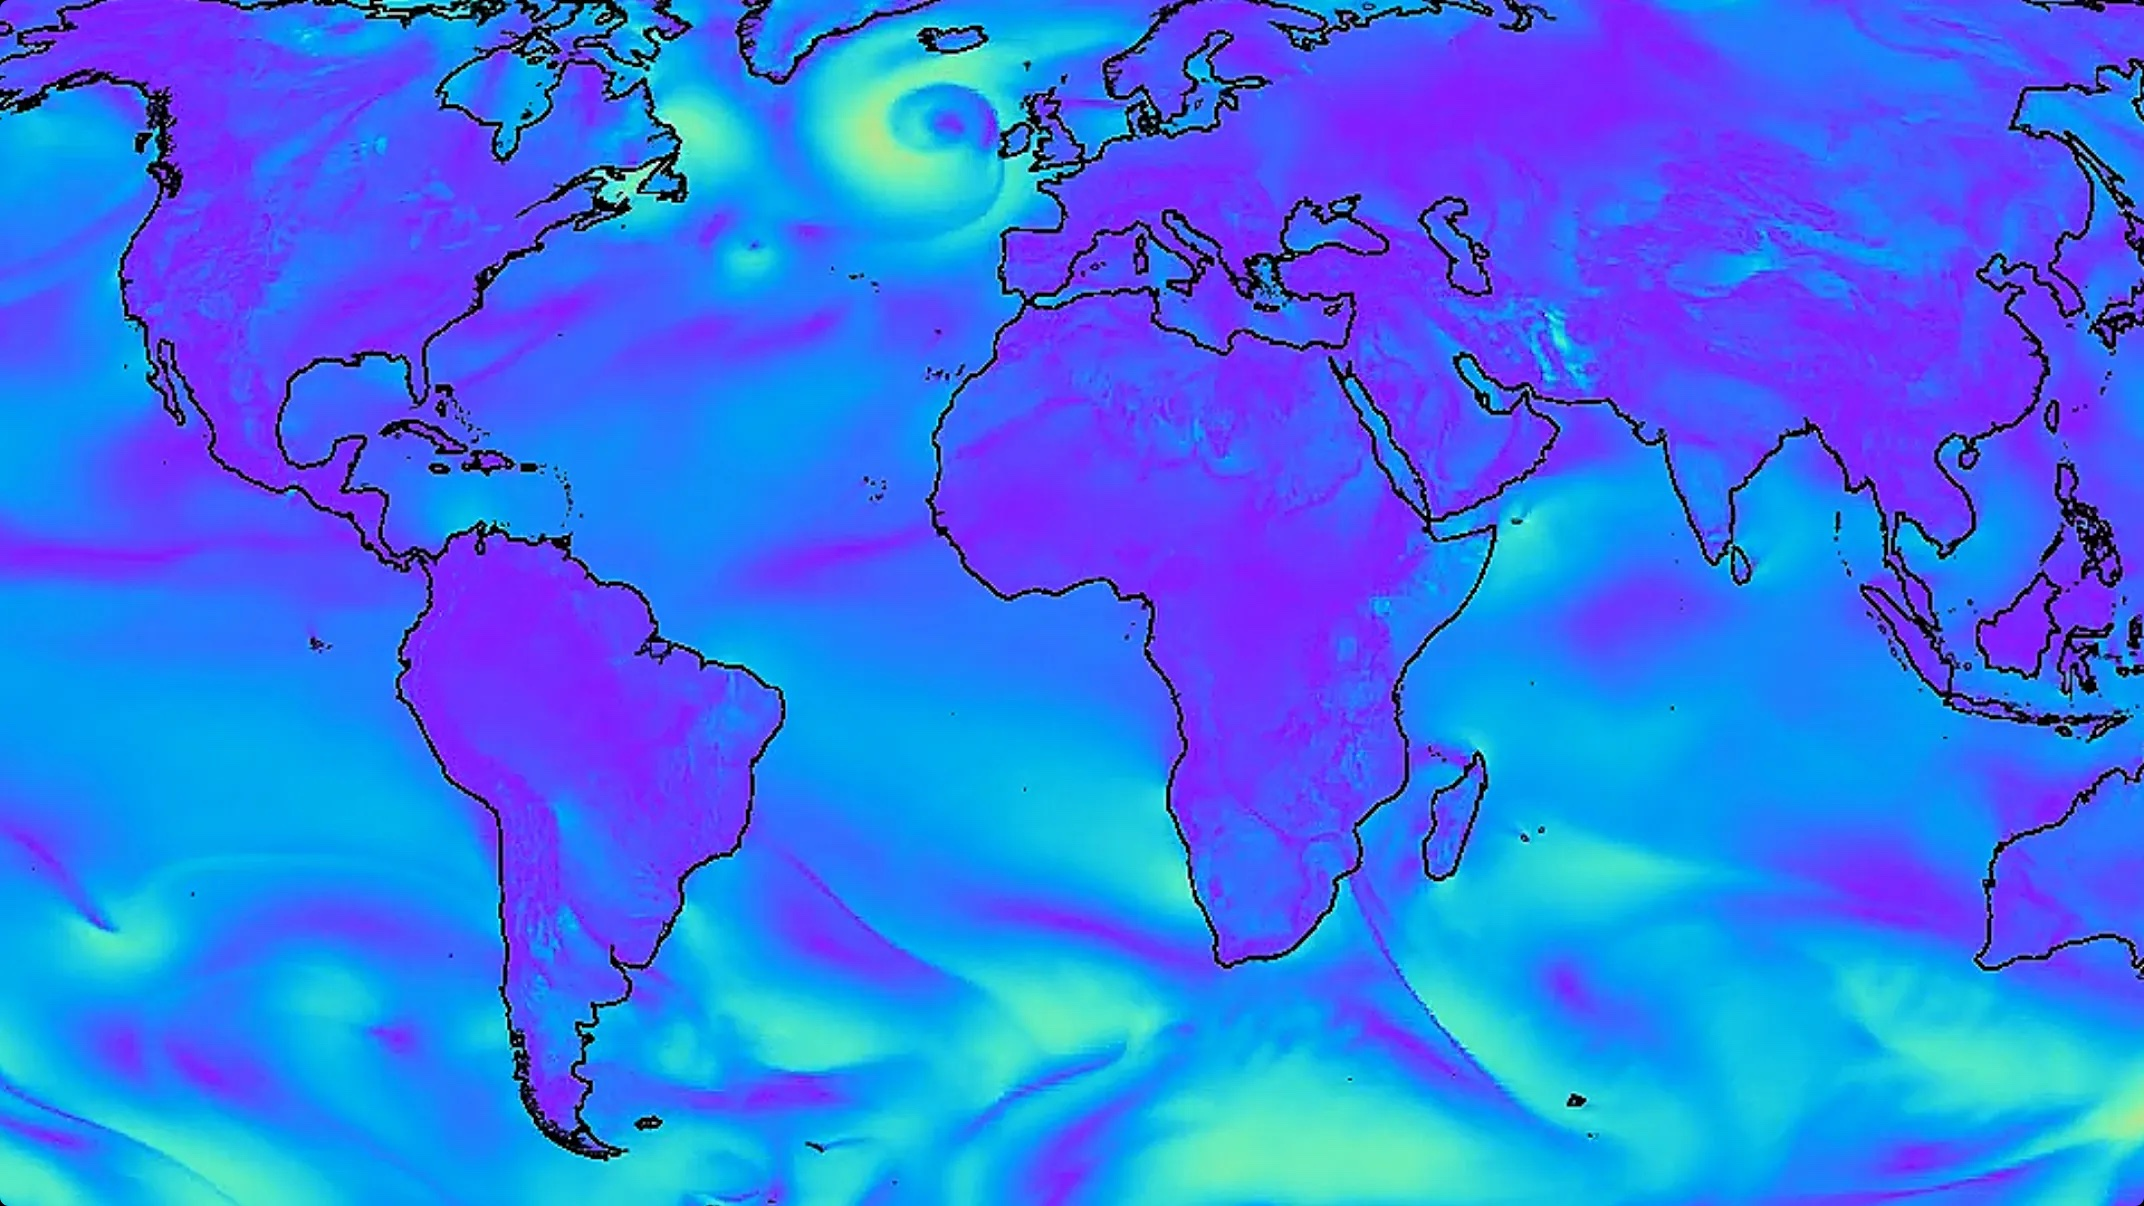

[Image Source](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/)

In this notebook, we will :


*   Undestand the structure of observation and forecast data
*   Explore some of the WeatherBench 2 framework basics around configuration and metrics
*   Define custom regions and asses performances over those

This notebook relies on the evaluation notebook provided by WeatherBench 2, please check the documentation at https://weatherbench2.readthedocs.io/en/latest/evaluation.html

# What is WeatherBench 2
WB2 is a framework for evaluating and comparing weather forecasting models. WB2 is publicly available and the evaluation framework is open source.
WB2 is an excellent starting point to understand the structure and metrics of weather data as well as baseline models.

We opted for WB2 also because of its cloud-optimized ground truth and baseline datasets. This means that during this tutorial, you will not have to worry about downloading high resolution forecasts and datasets.  

WB2 has several datasets and baselines available at : https://console.cloud.google.com/storage/browser/weatherbench2

After going through this tutorial, feel free to play with other available baselines, their diffrent resolutions and forecast dates !


In this tutorial, we will need only two packages. **WeatherBench2** (of course!) and **xarray**.

From the official **xarray** documentation : *"Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like multidimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience."*

Cool right ! Let's install/import them.


In [ ]:
# Install WB2
!pip install git+https://github.com/google-research/weatherbench2.git

  Cloning https://github.com/google-research/weatherbench2.git to /tmp/pip-req-build-hase4ekw
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbench2.git /tmp/pip-req-build-hase4ekw
  Resolved https://github.com/google-research/weatherbench2.git to commit 2aa282a6dca3c88f1941aea341a02ba3d81358aa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py)

In [ ]:
import weatherbench2
import xarray as xr

In [ ]:
# Run the code below to access cloud data files from the public WB2 bucket
from google.colab import auth
auth.authenticate_user()

## Assesing GraphCast against ERA5 Reanalysis Data


 In this tutorial, we will be assesing the medium range forecasting skill of [GraphCast](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/) (forecast) against era5 (observation)



[GraphCast](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/) is a machine learning-based weather forecasting system developed by Google DeepMind. It utilises graph neural networks (GNNs) to learn complex relationships between different regions of the Earth's atmosphere, aiming to provide more accurate and efficient weather predictions compared to traditional numerical weather prediction methods.

[ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview), standing for ECMWF Reanalysis v5, is the latest generation atmospheric reanalysis produced by the European Centre for Medium-Range Weather Forecasts (ECMWF). It's a comprehensive dataset offering hourly estimates of a wide range of atmospheric, land-surface, and sea-surface conditions for the entire globe since January 1940. We use ERA5 as proxy for observations in this tutorial.

If you later want to choose different baselines or models, you'll need to pay extra attention that the date range and resolution match.

In [ ]:
forecast_path='gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'

In [ ]:
#Let us have a look at the data we will play with
# Take some time to look at the wealth of data variables available for our evaluation
forecast_data=xr.open_zarr(forecast_path)
forecast_data
# you can also check the observation data and that the variables do match
# xr.open_zarr(obs_path)

<xarray.Dataset>
Dimensions:                   (time: 886, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int64 1 2 3 5 7 ... 900 925 950 975 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2019-11-16 ... 2021-01-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>

In [ ]:
# Geopotential in weather forecasting refers to the potential energy per unit mass of air at a specific altitude, used to understand atmospheric dynamics and predict weather patterns.
forecast_data["geopotential"]

<xarray.DataArray 'geopotential' (time: 886, prediction_timedelta: 40,
                                  level: 37, longitude: 64, latitude: 32)>
dask.array<open_dataset-geopotential, shape=(886, 40, 37, 64, 32), dtype=float32, chunksize=(4, 1, 37, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 1 2 3 5 7 10 ... 900 925 950 975 1000
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days 06:00...
  * time                  (time) datetime64[ns] 2019-11-16 ... 2021-01-31T12:...

### Set up WeatherBench configuration

With WB2, we need to define configuration for the


*   data : the paths where the data is at **and** which weather variables we care about
*   evaluation : the evaluation metrics we would like to use (MSE, RMSE, ACC..etc)



#### Data configuration


In [ ]:
from weatherbench2 import config
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

Here, we chose three common variables but you are encouraged to go back up to the list of available weather variables and select differently.

**Just keep in mind that more variables, more pressure levels and larger time ranges will heavily impact the evaluation time.**

In [ ]:
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        'total_precipitation_24hr',
    ],
    levels=[500],
    time_slice=slice('2019-11-16', '2020-02-01'),
)

We then have our data config ready


In [ ]:
data_config = config.Data(selection=selection, paths=paths)

### Evaluation configuration

Evaluation config allows to define the **metrics** we want to evaluate our model against and a **geographical region** of the forecast.

### Geographical regions
Geographical regions can be import from `weatherbench2.regions` but unfortunatelly the number of pre-defined regions is limited. We can however define our own geographical box using spatial coordinates !

**consider creating a PR to extend the regions available in WB2**

### A geographical box for Africa
Let us build a coordinates box that contains the African continent


*   Northernmost point: Close to 37° N (Ras ben Sakka, Tunisia)
*   Southernmost point: About 34.8° S (Cape Agulhas, South Africa)
*   Westernmost point: Near 17.5° W (Cap Vert Peninsula, Senegal)
*   Easternmost point: Approximately 51.4° E (Ras Hafun, Somalia)

Therefore, a latitude and longitude box that contains Africa would be roughly:

*   North: 37° N
*   South: 34.8° S
*   West: 17.5° W
*   East: 51.4° E

![africa](https://www.imk-tro.kit.edu/download/cordex-fig1.jpg)

[Image Source](https://www.imk-tro.kit.edu/english/6997.php)

In [ ]:
from weatherbench2.regions import SliceRegion

AfricanRegion=SliceRegion(lat_slice=slice(-34.8, 37), lon_slice=slice(-17.5,51.4))

regions = {
    'global': SliceRegion(),
    'africa':AfricanRegion,
    'europe': SliceRegion(
          lat_slice=slice(35, 75),
          lon_slice=[slice(360 - 12.5, None), slice(0, 42.5)],
      )
}

Our evaluation config is then ready

In [ ]:
from weatherbench2.metrics import MSE
eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
      },
      regions=regions
  )
}

### Evaluate


In [ ]:
from weatherbench2.evaluation import evaluate_in_memory

In [ ]:
evaluate_in_memory(data_config, eval_configs)   # Takes several minutes

### Results

Results are saved as NetCDF files under the name of the eval config.

In [ ]:
results = xr.open_dataset('./deterministic.nc')
results

<xarray.Dataset>
Dimensions:                   (lead_time: 40, region: 4, metric: 2, level: 1)
Coordinates:
  * lead_time                 (lead_time) timedelta64[ns] 0 days 06:00:00 ......
  * region                    (region) object 'global' 'weurope' ... 'europe'
  * metric                    (metric) object 'acc' 'mse'
  * level                     (level) int32 500
Data variables:
    geopotential              (metric, region, lead_time, level) float64 ...
    wind_speed                (metric, region, lead_time, level) float64 ...
    2m_temperature            (metric, region, lead_time) float64 ...
    total_precipitation_24hr  (metric, region, lead_time) float64 ...

Note that to compute the RMSE, we follow ECMWF's convention by taking the square root after the time mean. To do this in WB2, first compute the MSE and then take the square root of the saved MSE results.

In [ ]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

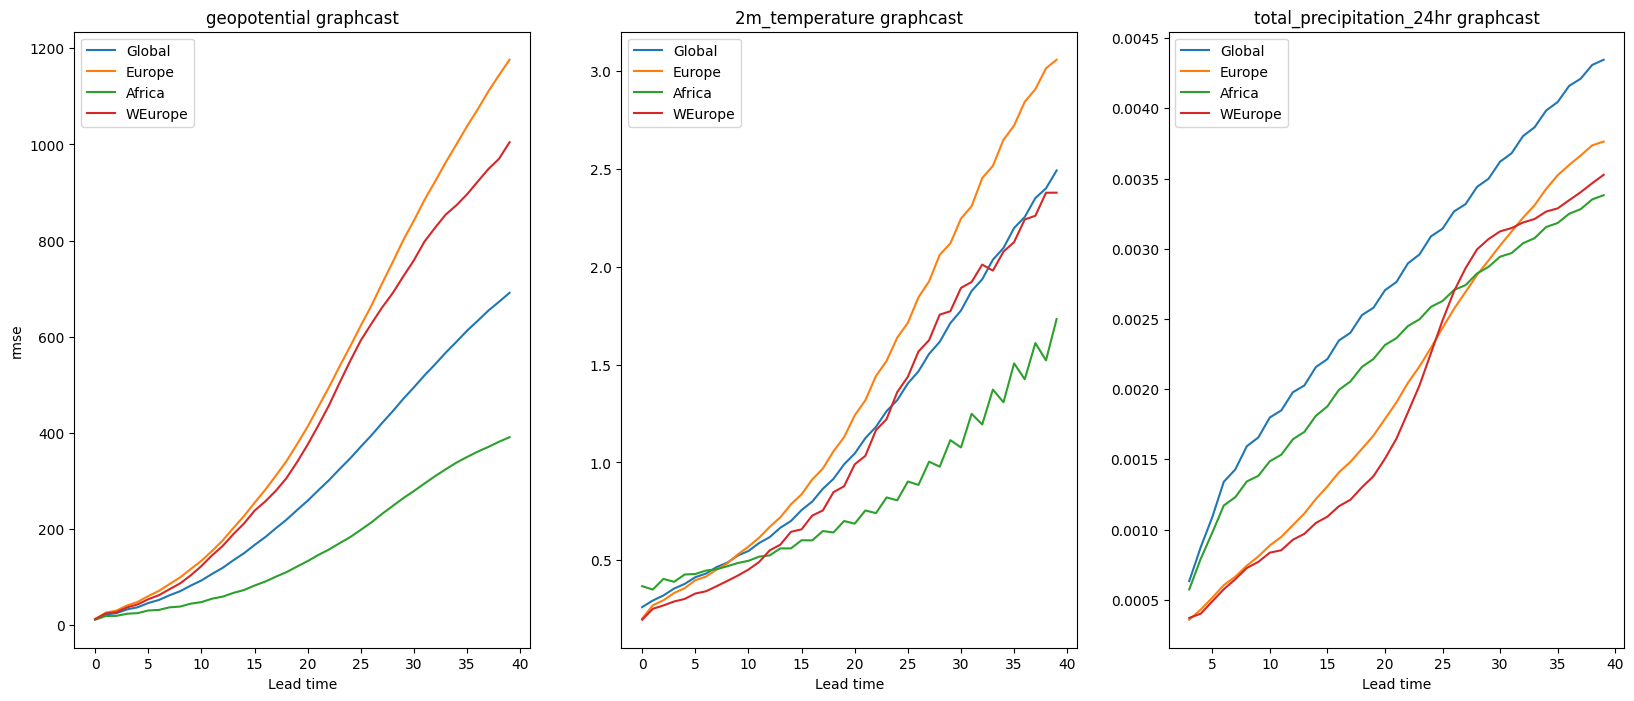

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.plot(results['geopotential'].sel(metric='rmse', region='global'),label="Global")
plt.plot(results['geopotential'].sel(metric='rmse', region='europe'),label="Europe")
plt.plot(results['geopotential'].sel(metric='rmse', region='africa'),label="Africa")
plt.plot(results['geopotential'].sel(metric='rmse', region='weurope'),label="WEurope")
plt.xlabel("Lead time")
plt.ylabel("rmse")
plt.title('geopotential graphcast')
plt.legend()



plt.subplot(1, 3, 2)
plt.plot(results['2m_temperature'].sel(metric='rmse', region='global'),label="Global")
plt.plot(results['2m_temperature'].sel(metric='rmse', region='europe'),label="Europe")
plt.plot(results['2m_temperature'].sel(metric='rmse', region='africa'),label="Africa")
plt.plot(results['2m_temperature'].sel(metric='rmse', region='weurope'),label="WEurope")
plt.xlabel("Lead time")
plt.title('2m_temperature graphcast')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(results['total_precipitation_24hr'].sel(metric='rmse', region='global'),label="Global")
plt.plot(results['total_precipitation_24hr'].sel(metric='rmse', region='europe'),label="Europe")
plt.plot(results['total_precipitation_24hr'].sel(metric='rmse', region='africa'),label="Africa")
plt.plot(results['total_precipitation_24hr'].sel(metric='rmse', region='weurope'),label="WEurope")
plt.xlabel("Lead time")
plt.title('total_precipitation_24hr graphcast')
plt.legend()

plt.show()

Somes ideas for next steps:



*   Can you use WeatherBench2 to perform skill assessment in your own country or region?
*   How does Graphcast compare to other  MLWP and/or NWP models [avalible](https://weatherbench2.readthedocs.io/en/latest/) on WeatherBench2?
*   ERA5 is a reanalysis dataset that we used as proxy for observations are you able to perform skill assessemnt on other *in-situ* observation proxies e.g CRU, GPCC etc.

